In [7]:
import math
from scripts_stock.cfg.out_file_name import OutFileName
from scripts_stock.cfg.set_dir import ProjectDir
from scripts_stock.cfg.stock_list import *
from scripts_stock.utils.analysis.stock_stat_index import df_to_stock_df, stock_kdj
import os
from scripts_stock.utils.common import CommonScript
from scripts_stock.utils.string_process import StringProcess


def get_data_sql_str(table):
    return f"""SELECT *  FROM {table} limit 10 """

def get_data_sql_str_macd(stock_index):
    return f"""SELECT *  FROM t_stock_kdj_daily_all where date>='2022-9-23' and stock_index={stock_index} """

def get_train_data():
    aa = f"""
    select t1.*,t2.diff_5,t2.diff_3_cate,t2.diff_5_cate,t2.diff_7_cate
    from t_stock_kdj_daily_all AS t1
    join t_stock_return_fuquan AS t2
    on t1.date=t2.date and t1.stock_index=t2.stock_index
    where close<8 and t2.date<='2024-09-01'
    """
    return aa

def get_predict_data():
    aa = f"""
    select t1.*,t2.diff_5,t2.diff_3_cate,t2.diff_5_cate,t2.diff_7_cate
    from t_stock_kdj_daily_all AS t1
    join t_stock_return_fuquan AS t2
    on t1.date=t2.date and t1.stock_index=t2.stock_index
    where close<8 and t2.date>='2024-09-01'
    """
    return aa

In [32]:
conn = CommonScript.connect_to_db("test.db")
cursor = conn.cursor()
df1 = pd.read_sql_query(get_data_sql_str_macd("601398"),conn)
print(df1[df1["date"]=="2024-09-18"].tail(5))

           date  open  close  high   low  stock_index   date_time  stock_date  \
414  2024-09-18  5.57   5.68  5.68  5.57       601398  2024-09-18  2024-09-18   

     macdh     cci  ...    kdjk   kdjd   kdjj  boll_ub  boll_lb   macd  macds  \
414 -0.053 -44.737  ...  33.493  20.68  59.12    6.738    5.212 -0.122 -0.069   

       wr_6  wr_10                 update_time  
414  14.815   54.0  2024-09-22 02:27:43.101738  

[1 rows x 23 columns]


In [8]:
conn = CommonScript.connect_to_db("test.db")
cursor = conn.cursor()
df1 = pd.read_sql_query(get_train_data(),conn)
# df1 = df1[df1["stock_index"]==601398]
df1["boll_diff"]= df1["boll_ub"] - df1["boll_lb"]
#df1.columns
features = [ 'macdh', 'cci', 'rsi_6', 'rsi_12', 'rsi_24', 'kdjk',
       'kdjd', 'kdjj', 'boll_ub', 'boll_lb','boll_diff', 'macd', 'macds', 'wr_6', 'wr_10']
df_pred_y = ['diff_3_cate']

df2 = df1[features+df_pred_y].dropna()
#print(df1.head(5))
df2.groupby(df_pred_y[0]).count()

,macdh,cci,rsi_6,rsi_12,rsi_24,kdjk,kdjd,kdjj,boll_ub,boll_lb,boll_diff,macd,macds,wr_6,wr_10
diff_3_cate,,,,,,,,,,,,,,,
0.0,100083,100083,100083,100083,100083,100083,100083,100083,100083,100083,100083,100083,100083,100083,100083
1.0,96095,96095,96095,96095,96095,96095,96095,96095,96095,96095,96095,96095,96095,96095,96095


train_test_data

In [9]:
from sklearn import tree#导入模块
from sklearn.model_selection import train_test_split
X = df2[features]
Y = df2[df_pred_y[0]]
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [318]:

clf=tree.DecisionTreeClassifier(max_depth=10)#实例化
clf=clf.fit(x_train,y_train)#用训练集数据训练模型
# result=clf.score(x_text,y_text)


In [319]:
import numpy as np
y_pred = clf.predict(x_test)
 
# 评估模型准确性
accuracy = np.mean(y_pred == y_test)
print(f"Decision Tree Accuracy: {accuracy}")

# y_pred = clf.predict(x_train)
 
# # 评估模型准确性
# accuracy = np.mean(y_pred == y_train)
# print(f"Decision Tree Accuracy: {accuracy}")

Decision Tree Accuracy: 0.5278677900194426


In [ ]:
from sklearn.tree import plot_tree # 树图
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), facecolor= 'g')
feature_names = features
target_names = [str(x) for x in df2[df_pred_y[0]].unique().tolist()]

plot_tree(clf, 
          feature_names = feature_names, 
          class_names = target_names, 
          filled = True, 
          rounded = True,
           fontsize=14)
plt.show()

In [322]:
import lightgbm as lgb
dtrain = lgb.Dataset(x_train, y_train)
deval = lgb.Dataset(x_test, y_test, reference=dtrain)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
params['metric'] = 'l2'
# bst = lgb.LGBMClassifier(
#                 num_boost_round=20,
#                 valid_sets=deval,
#                 callbacks=[lgb.early_stopping(stopping_rounds=5)])
bst = lgb.LGBMClassifier(objective='binary')
# # Training with 5-fold CV:
# lgb.cv(params, dtrain, num_boost_round=20, nfold=5)
bst.fit(x_train, y_train)

y_pred = bst.predict(x_test)
y_pred_prob = bst.predict_proba(x_test)

accuracy = np.mean(y_pred == y_test)
print(f"Decision Tree Accuracy: {accuracy}")


Decision Tree Accuracy: 0.5669151004536617


In [386]:
import torch
from torch import nn


rnn = nn.LSTM(10, 20, 2)

input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [27]:
import torch
from torch.nn import Module, LSTM, Linear
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

frame = "pytorch" 
class Config:
    # 数据参数
    feature_columns = list(range(2, 9))     # 要作为feature的列，按原数据从0开始计算，也可以用list 如 [2,4,6,8] 设置
    label_columns = [4, 5]                  # 要预测的列，按原数据从0开始计算, 如同时预测第四，五列 最低价和最高价
    # label_in_feature_index = [feature_columns.index(i) for i in label_columns]  # 这样写不行
    label_in_feature_index = (lambda x,y: [x.index(i) for i in y])(feature_columns, label_columns)  # 因为feature不一定从0开始

    predict_day = 1             # 预测未来几天

    # 网络参数
    input_size = len(feature_columns)
    output_size = len(label_columns)

    hidden_size = 128           # LSTM的隐藏层大小，也是输出大小
    lstm_layers = 2             # LSTM的堆叠层数
    dropout_rate = 0.2          # dropout概率
    time_step = 20              # 这个参数很重要，是设置用前多少天的数据来预测，也是LSTM的time step数，请保证训练数据量大于它

    # 训练参数
    do_train = True
    do_predict = True
    add_train = False           # 是否载入已有模型参数进行增量训练
    shuffle_train_data = True   # 是否对训练数据做shuffle
    use_cuda = False            # 是否使用GPU训练

    train_data_rate = 0.95      # 训练数据占总体数据比例，测试数据就是 1-train_data_rate
    valid_data_rate = 0.15      # 验证数据占训练数据比例，验证集在训练过程使用，为了做模型和参数选择

    batch_size = 64
    learning_rate = 0.001
    epoch = 2                  # 整个训练集被训练多少遍，不考虑早停的前提下
    patience = 5                # 训练多少epoch，验证集没提升就停掉
    random_seed = 42            # 随机种子，保证可复现

    do_continue_train = False    # 每次训练把上一次的final_state作为下一次的init_state，仅用于RNN类型模型，目前仅支持pytorch
    continue_flag = ""           # 但实际效果不佳，可能原因：仅能以 batch_size = 1 训练
    if do_continue_train:
        shuffle_train_data = False
        batch_size = 1
        continue_flag = "continue_"

    # 训练模式
    debug_mode = False  # 调试模式下，是为了跑通代码，追求快
    debug_num = 500  # 仅用debug_num条数据来调试

    # 框架参数
    used_frame = frame  # 选择的深度学习框架，不同的框架模型保存后缀不一样
    model_postfix = {"pytorch": ".pth", "keras": ".h5", "tensorflow": ".ckpt"}
    model_name = "model_" + continue_flag + used_frame + model_postfix[used_frame]

    do_train_visualized = False 

class Net(Module):
    '''
    pytorch预测模型，包括LSTM时序预测层和Linear回归输出层
    可以根据自己的情况增加模型结构
    '''
    def __init__(self, config):
        super(Net, self).__init__()
        self.lstm = LSTM(input_size=config.input_size, hidden_size=config.hidden_size,
                         num_layers=config.lstm_layers, batch_first=True, dropout=config.dropout_rate)
        self.linear = Linear(in_features=config.hidden_size, out_features=config.output_size)

    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        linear_out = self.linear(lstm_out)
        return linear_out, hidden

[Errno 99] Cannot assign requested address


In [31]:
#x_train

x_train_tr = x_train.values.reshape(1, len(x_train), len(x_train.columns))  # 1是batch_size


[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address


In [30]:

train_X, train_Y = torch.from_numpy(x_train_tr).float(), torch.from_numpy(y_train.values).float() 
train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=200) 

AssertionError: 

[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] 

In [29]:
# import visdom
# vis = visdom.Visdom(env='model_pytorch')
from pexpect import ExceptionPexpect


train_X, train_Y = torch.from_numpy(x_train_tr).float(), torch.from_numpy(y_train.values).float() 
train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=200) 
config = Config()
device = torch.device("cpu") # CPU训练还是GPU
model = Net(config).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()      # 这两句是定义优化器和loss

valid_loss_min = float("inf")
bad_epoch = 0
global_step = 0

for epoch in range(config.epoch):
    print("+++++++++++++++++++++++++++++++++++++++++++++")
    print(("Epoch {}/{}".format(epoch, config.epoch)))
    model.train() 
    train_loss_array = []
    hidden_train = None
    for i, _data in enumerate(train_loader):
        try:
            _train_X, _train_Y = _data[0].to(device),_data[1].to(device)
            optimizer.zero_grad()               # 训练前要将梯度信息置 0
            pred_Y, hidden_train = model(_train_X, hidden_train)    # 这里走的就是前向计算forward函数

            if not config.do_continue_train:
                hidden_train = None             # 如果非连续训练，把hidden重置即可
            else:
                h_0, c_0 = hidden_train
                h_0.detach_(), c_0.detach_()    # 去掉梯度信息
                hidden_train = (h_0, c_0)
            loss = criterion(pred_Y, _train_Y)  # 计算loss
            loss.backward()                     # 将loss反向传播
            optimizer.step()                    # 用优化器更新参数
            train_loss_array.append(loss.item())
            global_step += 1
            if config.do_train_visualized and global_step % 100 == 0:   # 每一百步显示一次
                print(train_loss_array)
                # vis.line(X=np.array([global_step]), Y=np.array([loss.item()]), win='Train_Loss',
                #             update='append' if global_step > 0 else None, name='Train', opts=dict(showlegend=True))
        except Exception as e:
            print(e)
            break

AssertionError: 

[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address


In [402]:
# -*- coding: UTF-8 -*-
"""
@author: hichenway
@知乎: 海晨威
@contact: lyshello123@163.com
@time: 2020/5/9 17:00
@license: Apache
pytorch 模型
"""

import torch
from torch.nn import Module, LSTM, Linear
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class Net(Module):
    '''
    pytorch预测模型，包括LSTM时序预测层和Linear回归输出层
    可以根据自己的情况增加模型结构
    '''
    def __init__(self, config):
        super(Net, self).__init__()
        self.lstm = LSTM(input_size=config.input_size, hidden_size=config.hidden_size,
                         num_layers=config.lstm_layers, batch_first=True, dropout=config.dropout_rate)
        self.linear = Linear(in_features=config.hidden_size, out_features=config.output_size)

    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        linear_out = self.linear(lstm_out)
        return linear_out, hidden


def train(config, logger, train_and_valid_data):
    if config.do_train_visualized:
        import visdom
        vis = visdom.Visdom(env='model_pytorch')

    train_X, train_Y, valid_X, valid_Y = train_and_valid_data
    train_X, train_Y = torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).float()     # 先转为Tensor
    train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=config.batch_size)    # DataLoader可自动生成可训练的batch数据

    valid_X, valid_Y = torch.from_numpy(valid_X).float(), torch.from_numpy(valid_Y).float()
    valid_loader = DataLoader(TensorDataset(valid_X, valid_Y), batch_size=config.batch_size)

    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu") # CPU训练还是GPU
    model = Net(config).to(device)      # 如果是GPU训练， .to(device) 会把模型/数据复制到GPU显存中
    if config.add_train:                # 如果是增量训练，会先加载原模型参数
        model.load_state_dict(torch.load(config.model_save_path + config.model_name))
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = torch.nn.MSELoss()      # 这两句是定义优化器和loss

    valid_loss_min = float("inf")
    bad_epoch = 0
    global_step = 0
    for epoch in range(config.epoch):
        logger.info("Epoch {}/{}".format(epoch, config.epoch))
        model.train()                   # pytorch中，训练时要转换成训练模式
        train_loss_array = []
        hidden_train = None
        for i, _data in enumerate(train_loader):
            _train_X, _train_Y = _data[0].to(device),_data[1].to(device)
            optimizer.zero_grad()               # 训练前要将梯度信息置 0
            pred_Y, hidden_train = model(_train_X, hidden_train)    # 这里走的就是前向计算forward函数

            if not config.do_continue_train:
                hidden_train = None             # 如果非连续训练，把hidden重置即可
            else:
                h_0, c_0 = hidden_train
                h_0.detach_(), c_0.detach_()    # 去掉梯度信息
                hidden_train = (h_0, c_0)
            loss = criterion(pred_Y, _train_Y)  # 计算loss
            loss.backward()                     # 将loss反向传播
            optimizer.step()                    # 用优化器更新参数
            train_loss_array.append(loss.item())
            global_step += 1
            if config.do_train_visualized and global_step % 100 == 0:   # 每一百步显示一次
                vis.line(X=np.array([global_step]), Y=np.array([loss.item()]), win='Train_Loss',
                         update='append' if global_step > 0 else None, name='Train', opts=dict(showlegend=True))

        # 以下为早停机制，当模型训练连续config.patience个epoch都没有使验证集预测效果提升时，就停止，防止过拟合
        model.eval()                    # pytorch中，预测时要转换成预测模式
        valid_loss_array = []
        hidden_valid = None
        for _valid_X, _valid_Y in valid_loader:
            _valid_X, _valid_Y = _valid_X.to(device), _valid_Y.to(device)
            pred_Y, hidden_valid = model(_valid_X, hidden_valid)
            if not config.do_continue_train: hidden_valid = None
            loss = criterion(pred_Y, _valid_Y)  # 验证过程只有前向计算，无反向传播过程
            valid_loss_array.append(loss.item())

        train_loss_cur = np.mean(train_loss_array)
        valid_loss_cur = np.mean(valid_loss_array)
        logger.info("The train loss is {:.6f}. ".format(train_loss_cur) +
              "The valid loss is {:.6f}.".format(valid_loss_cur))
        if config.do_train_visualized:      # 第一个train_loss_cur太大，导致没有显示在visdom中
            vis.line(X=np.array([epoch]), Y=np.array([train_loss_cur]), win='Epoch_Loss',
                     update='append' if epoch > 0 else None, name='Train', opts=dict(showlegend=True))
            vis.line(X=np.array([epoch]), Y=np.array([valid_loss_cur]), win='Epoch_Loss',
                     update='append' if epoch > 0 else None, name='Eval', opts=dict(showlegend=True))

        if valid_loss_cur < valid_loss_min:
            valid_loss_min = valid_loss_cur
            bad_epoch = 0
            torch.save(model.state_dict(), config.model_save_path + config.model_name)  # 模型保存
        else:
            bad_epoch += 1
            if bad_epoch >= config.patience:    # 如果验证集指标连续patience个epoch没有提升，就停掉训练
                logger.info(" The training stops early in epoch {}".format(epoch))
                break


def predict(config, test_X):
    # 获取测试数据
    test_X = torch.from_numpy(test_X).float()
    test_set = TensorDataset(test_X)
    test_loader = DataLoader(test_set, batch_size=1)

    # 加载模型
    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")
    model = Net(config).to(device)
    model.load_state_dict(torch.load(config.model_save_path + config.model_name))   # 加载模型参数

    # 先定义一个tensor保存预测结果
    result = torch.Tensor().to(device)

    # 预测过程
    model.eval()
    hidden_predict = None
    for _data in test_loader:
        data_X = _data[0].to(device)
        pred_X, hidden_predict = model(data_X, hidden_predict)
        # if not config.do_continue_train: hidden_predict = None    # 实验发现无论是否是连续训练模式，把上一个time_step的hidden传入下一个效果都更好
        cur_pred = torch.squeeze(pred_X, dim=0)
        result = torch.cat((result, cur_pred), dim=0)

    return result.detach().cpu().numpy()    # 先去梯度信息，如果在gpu要转到cpu，最后要返回numpy数据

TypeError: new(): argument 'size' must be tuple of ints, but found element of type tuple at pos 2

In [330]:
clf_loads = lgb.Booster(model_file='/home/davidyu/vscode/model/model_1_55.0.txt')


In [326]:
def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Decision Tree Accuracy: 0.75


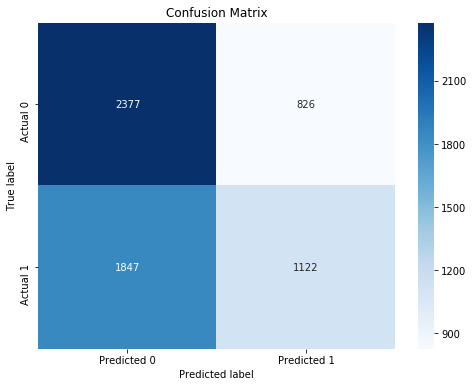

In [329]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

df_pred1 = pd.DataFrame()
df_pred1["pred_binary"] = y_pred
df_pred1["pred_prob"] = [x[1] for x in y_pred_prob]
df_pred1["pred_prob_bin"] =  np.where(df_pred1['pred_prob'] > 0.7, 1,0)
df_pred1["pred_truth"] = y_test
df_pred2 = df_pred1.dropna()
df_pred3 = df_pred2[df_pred2["pred_prob_bin"]==1]

accuracy = np.mean(df_pred3["pred_prob_bin"] == df_pred3["pred_truth"])
print(f"Decision Tree Accuracy: {accuracy}")


cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()



In [316]:
df_pred3

,pred_binary,pred_prob,pred_prob_bin,pred_truth
796,1.0,0.705228,1,1.0
1640,1.0,0.795987,1,1.0
2480,1.0,0.713636,1,1.0
3333,1.0,0.744004,1,0.0
4817,1.0,0.704762,1,0.0
4838,1.0,0.703187,1,0.0
5662,1.0,0.726294,1,0.0
5946,1.0,0.704220,1,0.0


In [324]:
feature_importance  = pd.DataFrame()
feature_importance['fea_name'] = features
feature_importance['fea_imp']  = bst.feature_importances_
feature_importance = feature_importance.sort_values('fea_imp',ascending = False)

print(feature_importance)

     fea_name  fea_imp
9     boll_lb      273
0       macdh      240
10  boll_diff      240
6        kdjd      233
12      macds      230
8     boll_ub      228
4      rsi_24      225
7        kdjj      197
1         cci      195
13       wr_6      184
11       macd      181
2       rsi_6      165
3      rsi_12      154
14      wr_10      143
5        kdjk      112


In [357]:
model_list


['model_2022_2024_60_54.txt',
 'model_2022_2024_37_54.txt',
 'model_2022_2024_23_55.txt',
 'model_2022_2024_54_55.txt',
 'model_2022_2024_44_54.txt',
 'model_2022_2024_0_54.txt',
 'model_2022_2024_92_54.txt',
 'model_2022_2024_56_55.txt',
 'model_2022_2024_6_54.txt',
 'model_2022_2024_64_54.txt',
 'model_2022_2024_36_54.txt',
 'model_2022_2024_63_54.txt',
 'model_2022_2024_89_55.txt',
 'model_2022_2024_40_54.txt',
 'model_2022_2024_17_55.txt',
 'model_2022_2024_46_54.txt',
 'model_2022_2024_27_54.txt',
 'model_2022_2024_35_54.txt',
 'model_2022_2024_76_54.txt',
 'model_2022_2024_43_54.txt',
 'model_2022_2024_25_55.txt',
 'model_2022_2024_59_54.txt',
 'model_2022_2024_74_55.txt',
 'model_2022_2024_83_54.txt',
 'model_2022_2024_45_54.txt',
 'model_2022_2024_7_54.txt',
 'model_2022_2024_10_54.txt',
 'model_2022_2024_94_55.txt',
 'model_2022_2024_38_55.txt',
 'model_2022_2024_77_54.txt',
 'model_2022_2024_51_55.txt',
 'model_2022_2024_88_54.txt',
 'model_2022_2024_80_55.txt',
 'model_2022_

In [353]:
conn = CommonScript.connect_to_db("test.db")
cursor = conn.cursor()
df1 = pd.read_sql_query(get_predict_data(),conn)
df1["boll_diff"]= df1["boll_ub"] - df1["boll_lb"]

#df_pred_check = df1.dropna()
df_pred_check = df1

# df1 = df1[df1["stock_index"]==601398]
#df1.columns
# features = [ 'macdh', 'cci', 'rsi_6', 'rsi_12', 'rsi_24', 'kdjk',
#        'kdjd', 'kdjj', 'boll_ub', 'boll_lb','boll_diff', 'macd', 'macds', 'wr_6', 'wr_10']
# df_pred_y = ['diff_7_cate']
df2_pred = df_pred_check[features+df_pred_y]

In [359]:
model_list = os.listdir('/home/davidyu/vscode/model/lgb_pred_return/')
col_in = []
for i in model_list[0:100]:
    model_dir = '/home/davidyu/vscode/model/lgb_pred_return'
    clf_loads = lgb.Booster(model_file=os.path.join(model_dir,i))
    y_pred_v2 = clf_loads.predict(df2_pred[features])
    #d_predict_proba= clf_loads.predict_proba(df2_pred[features])
    #pred_prob = [ x[1] for x in d_predict_proba]
    df_pred_check["pred_"+i]=y_pred_v2
    #df_pred_check["pred_prob_"+model_col] = pred_prob
    col_in.append("pred_"+i)

df_out = df_pred_check[["stock_index","date","diff_5_cate"]+col_in].round(3)

In [374]:
def count_greater_than_0_5(row):
    return (row > 0.5).sum()

def row_max(row):
    return row.max()
df_out['Count_GT_0_5'] = df_out[col_in].apply(count_greater_than_0_5, axis=1)
df_out['model_max'] = df_out[col_in].apply(row_max, axis=1)

df_out1 = df_out[["stock_index","date","diff_5_cate"]+['Count_GT_0_5','model_max']].dropna()

# df_out1.groupby("diff_5_cate").mean()
df_out1.sort_values('model_max',ascending=False).head(30)
#df_out.groupby()

,stock_index,date,diff_5_cate,Count_GT_0_5,model_max
428,601872,2024-09-09,1.0,100,0.647
389,601800,2024-09-09,0.0,98,0.643
737,601328,2024-09-05,0.0,94,0.632
427,601872,2024-09-06,0.0,96,0.632
724,601186,2024-09-05,0.0,94,0.629
388,601800,2024-09-06,0.0,93,0.627
736,601328,2024-09-04,0.0,90,0.626
727,601186,2024-09-10,0.0,100,0.623
652,601939,2024-09-09,1.0,78,0.622
738,601328,2024-09-06,0.0,96,0.620


In [337]:
clf_loads = lgb.Booster(model_file='/home/davidyu/vscode/model/lgb_pred_return/model_73_55.0.txt')
y_pred_v2 = bst.predict(df2_pred[features])
d_predict_proba= bst.predict_proba(df2_pred[features])
pred_prob = [ x[1] for x in d_predict_proba]
df_pred_check["pred"]=y_pred_v2
df_pred_check["pred_prob"] = pred_prob

df_pred_check

,date,open,close,high,low,stock_index,date_time,stock_date,macdh,cci,...,wr_6,wr_10,update_time,diff_5,diff_3_cate,diff_5_cate,diff_7_cate,boll_diff,pred,pred_prob
0,2024-09-02,6.93,6.94,7.04,6.88,600011,2024-09-02,2024-09-02,0.018,-85.763,...,72.414,85.965,2024-09-22 02:27:43.101738,-0.049,0.0,0.0,0.0,0.841,0.0,0.381604
1,2024-09-03,6.94,6.84,6.98,6.79,600011,2024-09-03,2024-09-03,0.016,-103.984,...,84.375,88.636,2024-09-22 02:27:43.101738,-0.037,0.0,0.0,0.0,0.869,0.0,0.398415
2,2024-09-04,6.82,6.76,6.85,6.73,600011,2024-09-04,2024-09-04,0.012,-125.132,...,92.105,94.000,2024-09-22 02:27:43.101738,-0.056,0.0,0.0,0.0,0.897,1.0,0.574510
3,2024-09-05,6.77,6.76,6.80,6.66,600011,2024-09-05,2024-09-05,0.012,-133.649,...,74.359,82.143,2024-09-22 02:27:43.101738,-0.053,0.0,0.0,0.0,0.930,1.0,0.564111
4,2024-09-06,6.75,6.67,6.86,6.66,600011,2024-09-06,2024-09-06,0.009,-125.696,...,97.368,97.959,2024-09-22 02:27:43.101738,-0.037,0.0,0.0,0.0,0.984,1.0,0.511897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,2024-09-12,5.70,5.74,5.76,5.69,600061,2024-09-12,2024-09-12,0.009,45.301,...,57.143,51.613,2024-09-22 02:27:43.101738,NaN,1.0,NaN,NaN,0.313,0.0,0.472048
973,2024-09-13,5.75,5.74,5.82,5.73,600061,2024-09-13,2024-09-13,0.008,79.288,...,57.143,57.143,2024-09-22 02:27:43.101738,NaN,1.0,NaN,NaN,0.298,0.0,0.430749
974,2024-09-18,5.74,5.81,5.83,5.69,600061,2024-09-18,2024-09-18,0.012,91.337,...,24.000,32.143,2024-09-22 02:27:43.101738,NaN,NaN,NaN,NaN,0.295,0.0,0.423503
975,2024-09-19,5.83,5.92,5.96,5.78,600061,2024-09-19,2024-09-19,0.021,213.295,...,11.765,11.765,2024-09-22 02:27:43.101738,NaN,NaN,NaN,NaN,0.352,0.0,0.439311


In [308]:
y_pred_v2 = bst.predict(df2_pred[features])
d_predict_proba= bst.predict_proba(df2_pred[features])
pred_prob = [ x[1] for x in d_predict_proba]
df_pred_check["pred"]=y_pred_v2
df_pred_check["pred_prob"] = pred_prob

accuracy = np.mean(y_pred_v2 == df_pred_check[df_pred_y])
print(f"Decision Tree Accuracy: {accuracy}")

# df_pred_check 
# df1[df1["stock_index"]==601658][["stock_index","date","diff_7_cate","pred"]]

ValueError: Unable to coerce to Series, length must be 1: given 977

In [309]:
def equal_rate(group):
    return (group[df_pred_y[0]] == group['pred']).mean()

# 使用 groupby 和 apply 计算每个组的相等率
result = df_pred_check.groupby('stock_index').apply(equal_rate).reset_index(name='Equal_Rate')
result.sort_values('Equal_Rate',ascending=False).head(30)

,stock_index,Equal_Rate
45,601169,0.692308
64,601766,0.692308
69,601868,0.692308
12,983,0.615385
26,600028,0.615385
30,600050,0.615385
54,601360,0.615385
18,2414,0.615385
37,600795,0.615385
57,601398,0.615385


In [310]:
df_v2 = df_pred_check[df_pred_check["stock_index"]==601728][["stock_index","date",df_pred_y[0],"pred","pred_prob"]].round(3)
accuracy = np.mean(df_v2[df_pred_y[0]]==df_v2["pred"])
print(f"Decision Tree Accuracy: {accuracy}")
df_v2

Decision Tree Accuracy: 0.46153846153846156


,stock_index,date,diff_3_cate,pred,pred_prob
26,601728,2024-09-02,0.0,1.0,0.603
27,601728,2024-09-03,0.0,0.0,0.438
28,601728,2024-09-04,0.0,0.0,0.418
29,601728,2024-09-05,1.0,0.0,0.477
30,601728,2024-09-06,1.0,0.0,0.475
31,601728,2024-09-09,0.0,0.0,0.436
32,601728,2024-09-10,0.0,0.0,0.414
33,601728,2024-09-11,0.0,0.0,0.405
34,601728,2024-09-12,0.0,0.0,0.461
35,601728,2024-09-13,1.0,0.0,0.467


In [312]:
dd1 = df_pred_check[["stock_index","date",df_pred_y[0],"pred","pred_prob"]].round(3).sort_values("pred_prob",ascending=False)
dd2 = dd1.dropna()
dd3 = dd2[dd2["pred_prob"]>0.7]
accuracy = np.mean(dd3[df_pred_y[0]]==dd3["pred"])
print(f"Decision Tree Accuracy: {accuracy}")

Decision Tree Accuracy: 0.3157894736842105


In [266]:
dd1[dd1["pred_prob"]>0.7]

,stock_index,date,diff_3_cate,pred,pred_prob
733,601186,2024-09-20,NaN,1.0,0.783
434,601872,2024-09-19,NaN,1.0,0.770
730,601186,2024-09-13,1.0,1.0,0.757
714,601766,2024-09-10,1.0,1.0,0.754
396,601800,2024-09-20,NaN,1.0,0.741
432,601872,2024-09-13,1.0,1.0,0.739
713,601766,2024-09-09,1.0,1.0,0.737
433,601872,2024-09-18,NaN,1.0,0.732
732,601186,2024-09-19,NaN,1.0,0.729
744,601328,2024-09-18,NaN,1.0,0.724


In [183]:
y_pred_v2 = bst.predict(df2_pred[features])
# df_out["pred"] = y_pred_v2
# df_out

In [173]:
accuracy = np.mean(y_pred_v2 == df1["diff_7_cate"])
print(f"Decision Tree Accuracy: {accuracy}")

/home/davidyu/software/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


ValueError: Lengths must match to compare

In [150]:
df1["pred"]=y_pred_v2
df1[df1["stock_index"]==601658][["stock_index","date","diff_7_cate","pred"]]

,stock_index,date,diff_7_cate,pred
974,601658,2024-08-08,1,1
975,601658,2024-08-09,1,1
976,601658,2024-08-12,1,1
977,601658,2024-08-13,1,1
978,601658,2024-08-14,1,1
979,601658,2024-08-15,1,1
980,601658,2024-08-16,1,1
981,601658,2024-08-19,1,1
982,601658,2024-08-20,0,1
983,601658,2024-08-21,0,0
